In [1]:
from os import path
import numpy as np
from matplotlib import pyplot as plt
import zarr
import tensorflow as tf
# import segmentation_models_3D as sm

In [2]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6


In [3]:
data_root = "../data"

X_train_path = path.join(data_root, "data_train.npz")
y_train_path = path.join(data_root, "labels_train.npz")

In [4]:
zarr_path = path.join(data_root, "training.zarr")
# zarr_grp = zarr.open_group(zarr_path, mode="w")
# zarr_grp.create_dataset(
#     "X",
#     data=np.load(X_train_path)["data"][None, ..., None],
#     chunks=(1, 64, 64, 64, 1),
#     dtype="float32",
# )
#
# zarr_grp.create_dataset(
#     "y",
#     data=np.load(y_train_path)["labels"][None, ..., None],
#     chunks=(1, 64, 64, 64, 1),
#     dtype="uint8",
# )

train = zarr.open_group(zarr_path, mode="r")

In [5]:
def get_inline(il_idx):
    return train.X[0, :, il_idx, :, 0], train.y[0, :, il_idx, :, 0]


def get_xline(xl_idx):
    return train.X[0, ..., xl_idx, 0], train.y[0, ..., xl_idx, 0]


def get_tslice(t_idx):
    return train.X[0, t_idx, ..., 0], train.y[0, t_idx, ..., 0]


mean, std = train.X[:].mean(), train.X[:].std()

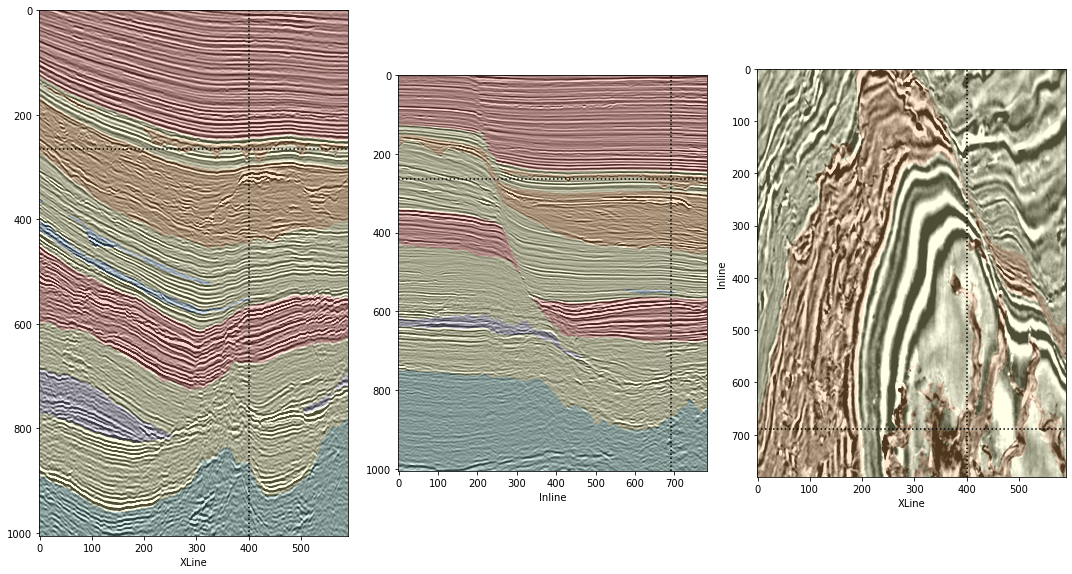

In [6]:
il_idx = 690
xl_idx = 400
t_idx = 265

il_data, il_label = get_inline(il_idx)
xl_data, xl_label = get_xline(xl_idx)
z_data, z_label = get_tslice(t_idx)

vmin, vmax = mean - std, mean + std
seismic_kw = dict(vmin=vmin, vmax=vmax, cmap="gray_r", interpolation="bicubic")
label_kw = dict(vmin=0.5, vmax=12.5, cmap="Set3", interpolation="nearest")

fig, ax = plt.subplots(1, 3, figsize=(15, 8))
ax[0].imshow(il_label, **label_kw)
ax[0].imshow(il_data, **seismic_kw, alpha=0.7)
ax[0].axhline(t_idx, color="k", linestyle=":")
ax[0].axvline(xl_idx, color="k", linestyle=":")
ax[0].set_xlabel("XLine")

ax[1].imshow(xl_label, **label_kw)
ax[1].imshow(xl_data, **seismic_kw, alpha=0.7)
ax[1].axhline(t_idx, color="k", linestyle=":")
ax[1].axvline(il_idx, color="k", linestyle=":")
ax[1].set_xlabel("Inline")

ax[2].imshow(z_label, **label_kw)
ax[2].imshow(z_data, **seismic_kw, alpha=0.7)
ax[2].axhline(il_idx, color="k", linestyle=":")
ax[2].axvline(xl_idx, color="k", linestyle=":")
ax[2].set_xlabel("XLine")
ax[2].set_ylabel("Inline")

fig.tight_layout()

In [7]:
patch_size = (128,) * 3
strides = (96,) * 3
batch_patch_size = (1,) + patch_size + (1,)
batch_strides = (1,) + strides + (1,)
#
# with tf.device('/cpu'):
#     X_full = tf.extract_volume_patches(train.X, batch_patch_size, batch_strides, padding="SAME")
#     y_full = tf.extract_volume_patches(train.y, batch_patch_size, batch_strides, padding="SAME")
#     X_full = (X_full - mean) / std
#
# X_full = tf.reshape(X_full, (-1,) + patch_size + (1,))
# y_full = tf.reshape(y_full, (-1,) + patch_size + (1,))

In [8]:
zarr_path = path.join(data_root, "training_patches.zarr")
# zarr_grp = zarr.open_group(zarr_path, mode="w")
# zarr_grp.create_dataset(
#     "X",
#     data=X_full.numpy(),
#     chunks=batch_patch_size,
#     dtype="float32",
# )
#
# zarr_grp.create_dataset(
#     "y",
#     data=y_full.numpy(),
#     chunks=batch_patch_size,
#     dtype="uint8",
# )

training_patches = zarr.open_group(zarr_path, mode="r")

(-1, 1)

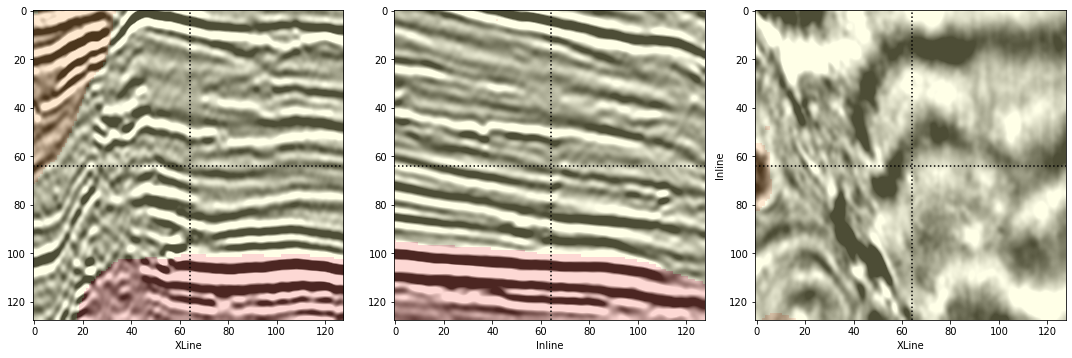

In [9]:
patch_idx = 200
il_idx = patch_size[1] // 2
xl_idx = patch_size[2] // 2
t_idx = patch_size[0] // 2

il_data, il_label = training_patches.X[patch_idx, :, il_idx, :, 0], training_patches.y[patch_idx, :, il_idx, :, 0]
xl_data, xl_label = training_patches.X[patch_idx, ..., xl_idx, 0], training_patches.y[patch_idx, ..., xl_idx, 0]
z_data, z_label = training_patches.X[patch_idx, t_idx, ..., 0], training_patches.y[patch_idx, t_idx]

vmin, vmax = -1, 1
seismic_kw = dict(vmin=vmin, vmax=vmax, cmap="gray_r", interpolation="bicubic")
label_kw = dict(vmin=0.5, vmax=12.5, cmap="Set3", interpolation="nearest")

fig, ax = plt.subplots(1, 3, figsize=(15, 8))
ax[0].imshow(il_label, **label_kw)
ax[0].imshow(il_data, **seismic_kw, alpha=0.7)
ax[0].axhline(t_idx, color="k", linestyle=":")
ax[0].axvline(xl_idx, color="k", linestyle=":")
ax[0].set_xlabel("XLine")

ax[1].imshow(xl_label, **label_kw)
ax[1].imshow(xl_data, **seismic_kw, alpha=0.7)
ax[1].axhline(t_idx, color="k", linestyle=":")
ax[1].axvline(il_idx, color="k", linestyle=":")
ax[1].set_xlabel("Inline")

ax[2].imshow(z_label, **label_kw)
ax[2].imshow(z_data, **seismic_kw, alpha=0.7)
ax[2].axhline(il_idx, color="k", linestyle=":")
ax[2].axvline(xl_idx, color="k", linestyle=":")
ax[2].set_xlabel("XLine")
ax[2].set_ylabel("Inline")

fig.tight_layout()
vmin, vmax

In [10]:
train_split = 0.9
BATCH_SIZE = 32

# full_ds = tf.data.Dataset.from_tensor_slices((training_patches.X, training_patches.y))
# full_ds = full_ds.shuffle(len(full_ds), seed=42)
# len(full_ds), len(full_ds) * train_split

In [11]:
# train_ds = full_ds.take(round(len(full_ds) * train_split))
# val_ds = full_ds.skip(round(len(full_ds) * train_split))
#
# train_ds = train_ds.batch(BATCH_SIZE)
# val_ds = val_ds.batch(BATCH_SIZE)
#
# train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
# val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
#
# len(train_ds), len(val_ds)

In [21]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = tf.keras.Input(shape=img_size + (1,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv3D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.PReLU(shared_axes=[1, 2, 3])(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.PReLU(shared_axes=[1, 2, 3])(x)
        x = layers.Conv3D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.PReLU(shared_axes=[1, 2, 3])(x)
        x = layers.Conv3D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling3D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv3D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.PReLU(shared_axes=[1, 2, 3])(x)
        x = layers.Conv3DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.PReLU(shared_axes=[1, 2, 3])(x)
        x = layers.Conv3DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling3D(2)(x)

        # Project residual
        residual = layers.UpSampling3D(2)(previous_block_activation)
        residual = layers.Conv3D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv3D(num_classes, 3, activation="softmax", padding="same", dtype='float32')(x)

    # Define the model
    model = tf.keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
tf.keras.backend.clear_session()

# Build model
model = get_model(patch_size, 7)

In [13]:
BACKBONE = 'efficientnetb0'

tf.keras.backend.clear_session()

model = sm.FPN(BACKBONE, input_shape=patch_size + (1,), classes=7, activation='softmax', encoder_weights=None)

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 1)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 64, 64, 64,   896         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64,   128        ['conv3d[0][0]']                 
 alization)                     32)                                                           

In [23]:
import dask.array as da
import numpy as np

def train_val_split(training_patches, seed=42):
    np.random.seed(seed)
    rand_idx = np.random.randint(0, len(training_patches.X), 10)
    val_mask = np.zeros(len(training_patches.X), dtype=bool)
    val_mask[rand_idx] = True

    X_val_da = da.from_zarr(training_patches.X)[val_mask]
    y_val_da = da.from_zarr(training_patches.y)[val_mask]

    X_train_da = da.from_zarr(training_patches.X)[~val_mask]
    y_train_da = da.from_zarr(training_patches.y)[~val_mask]

    return X_train_da, y_train_da, X_val_da, y_val_da

X_train_da, y_train_da, X_val_da, y_val_da = train_val_split(training_patches)
X_train_da = X_train_da + da.random.standard_normal(X_train_da.shape, chunks=X_train_da.chunks) * 0.01

decimate_mask = np.zeros(patch_size[0], dtype='bool')
decimate_mask[::32] = 1
xls = y_train_da.copy()

# do ils
y_train_da[:, :, ~decimate_mask, ...] = 0

# do xls
xls[:, :, :, ~decimate_mask] = 0
y_train_da[:, :, :, decimate_mask] = xls[:, :, :, decimate_mask]

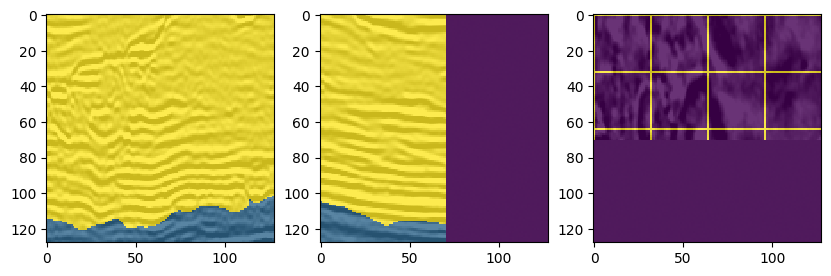

In [24]:
fig, ax = plt.subplots(1, 3, dpi=100, figsize=(10, 5))
ax[0].imshow(y_train_da[305, :, 64, :, 0], interpolation='none', vmin=0, vmax=6)
ax[0].imshow(X_train_da[305, :, 64, :, 0], interpolation='none', vmin=-1, vmax=1, alpha=0.2, cmap='gray_r')
ax[1].imshow(y_train_da[305, :, :, 64, 0], interpolation='none', vmin=0, vmax=6)
ax[1].imshow(X_train_da[305, :, :, 64, 0], interpolation='none', vmin=-1, vmax=1, alpha=0.2, cmap='gray_r')
ax[2].imshow(y_train_da[305, 64, :, :, 0], interpolation='none', vmin=0, vmax=6)
ax[2].imshow(X_train_da[305, 64, :, :, 0], interpolation='none', vmin=-1, vmax=1, alpha=0.2, cmap='gray_r')

Class weights for sparsified data.

In [25]:
# counts = [da.sum(y_train_da == label, dtype='uint32').compute() for label in range(1, 7)]
# total = np.sum(counts)
# class_weights = [1 - (count / total) for count in counts]
# class_weights  # class weights (without 0)

In [26]:
# redneck "augment"
X_train_flip_il = da.flip(X_train_da, 2) + da.random.standard_normal(X_train_da.shape, chunks=X_train_da.chunks) * 0.3
y_train_flip_il = da.flip(y_train_da, 2)

X_train_flip_xl = da.flip(X_train_da, 3) + da.random.standard_normal(X_train_da.shape, chunks=X_train_da.chunks) * 0.3
y_train_flip_xl = da.flip(y_train_da, 3)

X_train_da = da.concatenate([X_train_da, X_train_flip_il, X_train_flip_xl], axis=0)
y_train_da = da.concatenate([y_train_da, y_train_flip_il, y_train_flip_xl], axis=0)

In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from focal_loss import SparseCategoricalFocalLoss, sparse_categorical_focal_loss
callbacks = [
    EarlyStopping(patience=31, verbose=1),
    ModelCheckpoint('facies_model.h5', verbose=1, save_best_only=True, save_weights_only=True),
    ReduceLROnPlateau(factor=1/3, patience=10, verbose=1),
]

def class_tversky(y_true, y_pred):
    smooth = 1e-6
    n_classes = 7

    y_true = tf.one_hot(y_true, n_classes)

    y_true = y_true[..., 1:]
    y_pred = y_pred[..., 1:]

    y_true_pos = tf.reshape(y_true, (-1, n_classes - 1))
    y_pred_pos = tf.reshape(y_pred, (-1, n_classes - 1))

    true_pos = tf.reduce_sum(y_true_pos * y_pred_pos, 0)
    false_neg = tf.reduce_sum(y_true_pos * (1-y_pred_pos), 0)
    false_pos = tf.reduce_sum((1-y_true_pos)*y_pred_pos, 0)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky_loss(y_true,y_pred,gamma,class_weight):
    per_class_tversky_loss = class_tversky(y_true, y_pred)
    per_class_focal_tversky_loss = tf.math.pow((1-per_class_tversky_loss), gamma)
    per_class_focal_tversky_loss = class_weight[1:] * per_class_focal_tversky_loss
    return tf.reduce_mean(per_class_focal_tversky_loss)

def combined_focal_loss(y_true, y_pred):
    class_weight = tf.convert_to_tensor([0, 0.85, 0.58, 0.96, 0.71, 0.99, 0.91], dtype='float32')
    loss1 = focal_tversky_loss(y_true, y_pred, gamma=0.75, class_weight=class_weight)
    loss2 = sparse_categorical_focal_loss(y_true, y_pred, gamma=2, class_weight=class_weight, from_logits=False)
    return 0.01 * loss1 + loss2

loss = SparseCategoricalFocalLoss(gamma=2, from_logits=False, class_weight=[0, 0.855, 0.565, 0.959, 0.722, 0.99, 0.91])
# loss = combined_focal_loss

optimizer = tf.keras.optimizers.Nadam(learning_rate = 0.001)
model.compile(optimizer=optimizer, loss=loss, metrics = ['sparse_categorical_accuracy'])

In [28]:
results = model.fit(
    x=X_train_da,
    y=y_train_da,
    validation_data=(X_val_da, y_val_da),
    batch_size=8,
    epochs=250,
    shuffle=True,
    callbacks=callbacks,
)

Epoch 1/250
257/257 [==============================] - ETA: 0s - loss: 0.0335 - sparse_categorical_accuracy: 0.0257WARNING:tensorflow:Keras is training/fitting/evaluating on array-like data. Keras may not be optimized for this format, so if your input data format is supported by TensorFlow I/O (https://github.com/tensorflow/io) we recommend using that to load a Dataset instead.

Epoch 1: val_loss improved from inf to 2.71757, saving model to facies_model.h5
257/257 [==============================] - 243s 862ms/step - loss: 0.0335 - sparse_categorical_accuracy: 0.0257 - val_loss: 2.7176 - val_sparse_categorical_accuracy: 0.2764 - lr: 0.0010
Epoch 2/250
257/257 [==============================] - ETA: 0s - loss: 0.0158 - sparse_categorical_accuracy: 0.0282
Epoch 2: val_loss improved from 2.71757 to 0.20747, saving model to facies_model.h5
257/257 [==============================] - 219s 851ms/step - loss: 0.0158 - sparse_categorical_accuracy: 0.0282 - val_loss: 0.2075 - val_sparse_categori

KeyboardInterrupt: 

In [21]:
plt.figure()
plt.semilogy(results.history['loss'])
plt.semilogy(results.history['val_loss'])
plt.twinx()
plt.plot(results.history['lr'])

NameError: name 'results' is not defined

<Figure size 432x288 with 0 Axes>

In [76]:
model.load_weights("facies_model.h5")

In [77]:
X_train_da, y_train_da, X_val_da, y_val_da = train_val_split(training_patches)

np.random.seed(None)
plot_idx = np.random.random_integers(0, X_train_da.shape[0], 10)

X_val_da = X_train_da[plot_idx]
y_val_da = y_train_da[plot_idx]

C:\Users\tasan\AppData\Local\Temp\ipykernel_29536\1561549699.py:4: DeprecationWarning: This function is deprecated. Please call randint(0, 683 + 1) instead
  plot_idx = np.random.random_integers(0, X_train_da.shape[0], 10)


In [78]:
val_predict = model.predict(X_val_da, batch_size=16)

In [79]:
K = tf.keras

def Mean_IOU(y_true, y_pred):
    nb_classes = tf.shape(y_pred)[-1]
    y_pred = tf.reshape(y_pred, (-1, nb_classes))
    y_true = tf.cast(tf.reshape(y_true, (-1, 1))[:, 0], 'int32')
    y_true = tf.one_hot(y_true, nb_classes)
    true_pixels = tf.argmax(y_true, axis=-1) # exclude background
    pred_pixels = tf.argmax(y_pred, axis=-1)
    iou = []
    flag = tf.convert_to_tensor(-1, dtype='float64')
    for i in range(1, nb_classes):
        true_labels = tf.equal(true_pixels, i)
        pred_labels = tf.equal(pred_pixels, i)
        inter = tf.cast(true_labels & pred_labels, 'int32')
        union = tf.cast(true_labels | pred_labels, 'int32')
        cond = (tf.math.reduce_sum(union) > 0) & (tf.math.reduce_sum(tf.cast(true_labels, 'int32')) > 0)
        res = tf.cond(cond, lambda: tf.math.reduce_sum(inter)/tf.math.reduce_sum(union), lambda: flag)
        iou.append(res)
    iou = tf.stack(iou)
    legal_labels = tf.greater(iou, flag)
    iou = tf.gather(iou, indices=tf.where(legal_labels))
    return tf.math.reduce_mean(iou)

# Mean_IOU(y_train_da[plot_idx, ..., 0], val_predict)
Mean_IOU(y_val_da[..., 0], val_predict)


<tf.Tensor: shape=(), dtype=float64, numpy=0.7255214309960384>

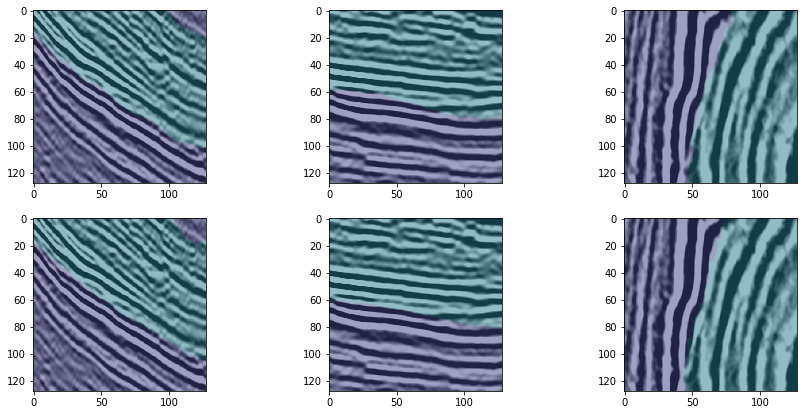

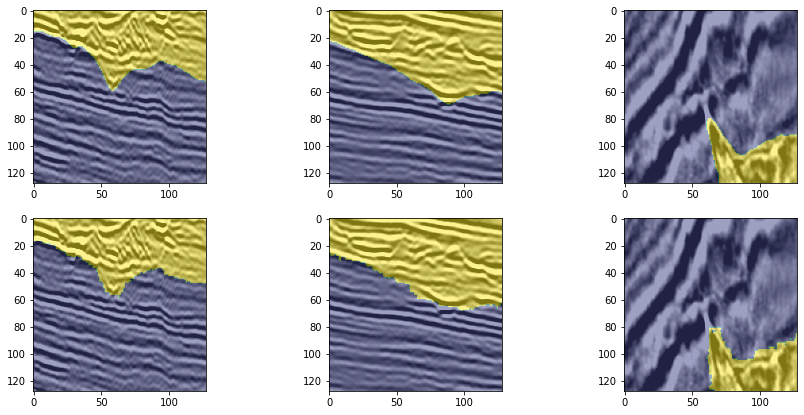

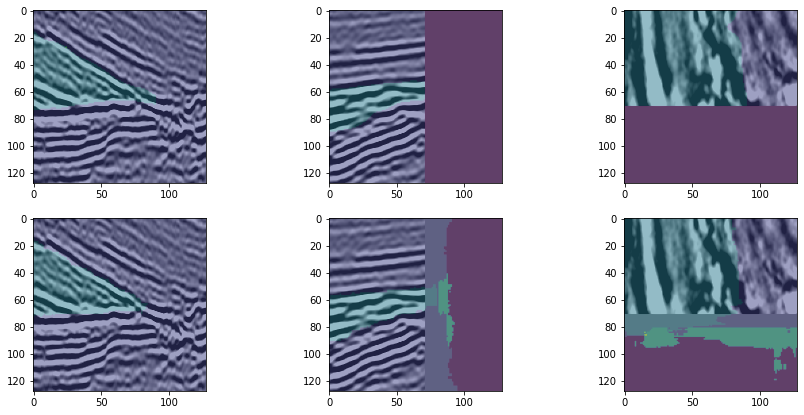

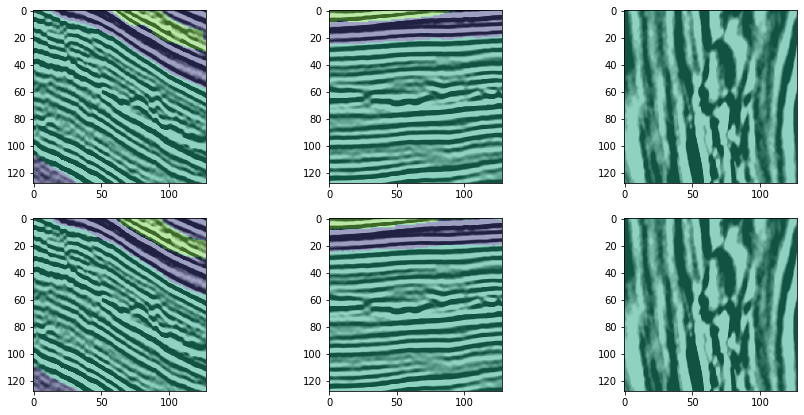

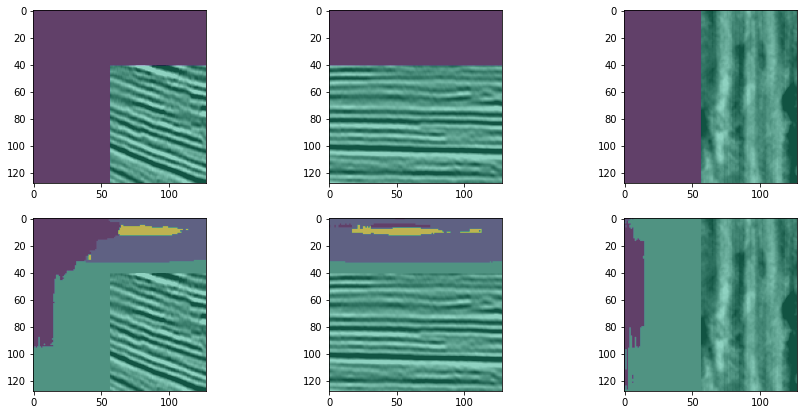

In [80]:
plt.close('all')

il_idx = patch_size[1] // 2
xl_idx = patch_size[2] // 2
t_idx = patch_size[0] // 2

for img in range(5):
    fig, ax = plt.subplots(2, 3, figsize=(15,7))

    ax[0, 0].imshow(y_val_da[img, ..., il_idx, :, 0], vmin=1, vmax=6)
    ax[0, 0].imshow(X_val_da[img, ..., il_idx, :, 0], alpha=0.5, vmin=-1, vmax=1, cmap='gray_r')

    ax[0, 1].imshow(y_val_da[img, ..., xl_idx, 0], vmin=1, vmax=6)
    ax[0, 1].imshow(X_val_da[img, ..., xl_idx, 0], alpha=0.5, vmin=-1, vmax=1, cmap='gray_r')

    ax[0, 2].imshow(y_val_da[img, t_idx, :, :, 0], vmin=1, vmax=6)
    ax[0, 2].imshow(X_val_da[img, t_idx, :, :, 0], alpha=0.5, vmin=-1, vmax=1, cmap='gray_r')

    ax[1, 0].imshow(val_predict[img, ..., il_idx, :, :].argmax(-1), vmin=1, vmax=6)
    ax[1, 0].imshow(X_val_da[img, ..., il_idx, :, 0], alpha=0.5, vmin=-1, vmax=1, cmap='gray_r')

    ax[1, 1].imshow(val_predict[img, ..., xl_idx, :].argmax(-1), vmin=1, vmax=6)
    ax[1, 1].imshow(X_val_da[img, ..., xl_idx, 0], alpha=0.5, vmin=-1, vmax=1, cmap='gray_r')

    ax[1, 2].imshow(val_predict[img, t_idx, ..., :].argmax(-1), vmin=1, vmax=6)
    ax[1, 2].imshow(X_val_da[img, t_idx, ..., 0], alpha=0.5, vmin=-1, vmax=1, cmap='gray_r')